# Mark Correlation function

__Author__: Victor Calderon

__Date__  : 10/25/2017

__Last Modified__  : 11/01/2017

---

## Mark Correlation Function - MCF

In the analysis of _galactic conformity_, we make use of the __mark correlation function__ (MCF; see [Skibba et al 2006](http://onlinelibrary.wiley.com/doi/10.1111/j.1365-2966.2006.10196.x/abstract) for more information).

The MCF has the format of:

\begin{align}
\mathcal{M}(r_{p}) &= \frac{1 + W(r_{p})}{1 + \xi(r_{p})} \equiv \frac{WW}{DD}
\label{eq:mcf}
\end{align}

where $\xi(r_{p})$ is the usual two-point correlation function with pairs summed 
in bins of projected separation $r_{p}$, and $W (r_{p})$ is the same except 
that galaxy pairs are weighted by the product of their marks. The estimator 
used in Equation \ref{eq:mcf} can also be written as $WW/DD$, where $DD$ 
is the raw number of galaxy pairs separated by $r_{p}$ and $WW$ is the 
weighted number of pairs.

In the _conformity analysis_ using MCF, we normalize by the _mean_ of the galaxy property
and then compute the MCF results.

In this notebook, we will look at how different distributions can produce MCF values 
centered __around 1__.

---
## Testing different distributions

Now we will test different distributions, and look at their _MCF_ results.

In [106]:
## Importing modules
%matplotlib inline
import os
import numpy as np
from numpy import random
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
import seaborn as sns
from tqdm import tqdm
sns.set('notebook',font_scale=1.5)
import astropy.cosmology as astrocosmo
import astropy.constants as ac
import astropy.units as u
import pandas as pd

In [107]:
def choice_distribution(distr='gaussian', samples=10000, **kwargs):
    """
    Produces an array drawn from `distr`
    
    Parameters
    ----------
    distr: string, optional (default = 'gaussian')
        choice of distribution to use
        Options:
            - 'gaussian': Gaussian distribution with `mean`, `std`, and amplitude `A`
            - 'uniform' : Uniform distribution with `low`, `high`
            - 'binomial': Binomial distribution with `p`and `n`
            - 'poisson' : Poisson distribution with `lam`
            - 'double gaussian': Double gaussian with `A1`, `mean1`, `std1`, `A2`, `mean2`, `std2`
    
    samples: int, optional (default = 10000)
        total of number of samples to compute
    
    Returns
    --------
    data_arr: numpy.ndarray, shape(samples,)
        array of values from `distr` distribution
    """
    # Gaussian Distribution
    if distr=='gaussian':
        data_arr = kwargs['A']*random.normal(loc=kwargs['mean'], scale=kwargs['std'], size=samples)
    # Uniform Distribution
    if distr=='uniform':
        data_arr = random.uniform(low=kwargs['low'],high=kwargs['high'],size=samples)
    # Bimodal Distribution
    if distr=='binomial':
        data_arr = random.binomial(n=kwargs['n'], p=kwargs['p'], size=samples)
    # Poisson Distribution
    if distr=='poisson':
        data_arr = random.poisson(lam=kwargs['lam'], size=samples)
    # Double-Gaussian Distribution
    if distr=='double gaussian':
        gauss_1  = kwargs['A1']*random.normal(loc=kwargs['mean1'], scale=kwargs['std1'], size=kwargs['sample1'])
        gauss_2  = kwargs['A2']*random.normal(loc=kwargs['mean2'], scale=kwargs['std2'], size=kwargs['sample2'])
        data_arr = np.concatenate((gauss_1, gauss_2))
    
    return data_arr

### Plotting different distributions
 Now we can plot the different distributions that we want
 
 

In [253]:
def distr_plotting(data_dict, fig_dir=None, savefig=False, name=None, sharex=False, xlim=None,
                  ncols=3, nrows=2, figsize=(15,10), ext_f='pdf'):
    """
    Plots the distributions of `data_arr`
    
    Parameters:
    -----------
    data_arr: python dictionary
        dictionary containing values of different distributions
    
    fig_dir: string or None
        path to the `figures` directory
    
    savefig: boolean, optional (default = False)
        option to save the figure to the `fig_dir` folder.
    """
    ## Creating new figure
    if sharex:
        fig, axes = plt.subplots(nrows, ncols, facecolor='white', figsize=figsize, sharex=True)
    else:
        fig, axes = plt.subplots(nrows, ncols, facecolor='white', figsize=figsize)
    cmap = mpl.cm.autumn
    ## Looping over keys in `data_dict`
    for ii, key in enumerate(data_dict.keys()):
        ax      = axes.flatten()[ii]
        data_ii = data_dict[key]
        color   = cmap(ii / float(len(data_dict.keys())))
        sns.distplot(data_ii, label=key, ax=axes.flatten()[ii],color=color)
        ## Mean and St. Dev.
        ax.axvline(x=data_ii.mean(), label='Mean: {0:.04f}'.format(data_ii.mean()))
        ax.axvspan(data_ii.mean() - data_ii.std(), data_ii.mean()+data_ii.std(),
                    color=color,alpha=0.4, label='St. Dev: {0:.3f}'.format(data_ii.std()))
        ax.legend(loc="upper left")
        ## Setting limits
        if xlim:
            ax.set_xlim(xlim)
    fig.suptitle(name)
    
    ## Saving figures
    if savefig:
        plt.savefig(os.path.join(fig_dir, 'MCF_distr_results_{0}.{1}'.format(name, ext_f)))
    

Now we can use the function that computes the MCF results!

In [109]:
def MCF_analysis(data_arr, itern=1000, stat_func = np.nanmean, return_mean=False):
    """
    Computes the Marked Correlation function for `data_arr` and determines 
    the distribution of the shuffled scenario.
    
    Parameters
    ----------
    data_arr: numpy.ndarray, shape(n,)
        array of values from a given distribution
    
    itern: int, optional (default = 1000)
        number of iterations to determine the shuffles
    
    stat_func: numpy function, optional (default = numpy.nanmean)
        statistical function used to normalize `data_arr`
    
    return_mean: boolean, optional (default = False)
        option for return the `mean` and `St. Dev.` of the MCF.
    
    Return
    ----------
    mcf_sh: numpy.ndarray, shape(itern,)
        results from shuffling `data_arr` `itern` times
    
    mcf_mean: float
        mean of the `mcf_sh`
    
    mcf_std: float
        standard deviation of the `mcf_sh`
    """
    ## Resetting random seed
    random.seed()
    ## Normalizing `data_arr`
    data_norm = data_arr / stat_func(data_arr)
    ## Iterating `itern` times and determining the product of the values
    mcf_sh = [np.product(random.choice(data_norm,2)) for x in range(itern)]
    mcf_sh = np.asarray(mcf_sh)
    ## Mean and St. Dev
    mcf_mean = stat_func(data_arr)
    mcf_std  = np.std(data_arr)
    
    if return_mean:
        return mcf_sh, mcf_mean, mcf_std
    else:
        return mcf_sh


## Plots

Now, we can create different plots to look at the distributions

In [110]:
### Pre-packaged initializers
distr_dict = {}
distr_dict['A'      ] = 10
distr_dict['mean'   ] = 10
distr_dict['std'    ] = 2.5
distr_dict['low'    ] = 10
distr_dict['high'   ] = 20
distr_dict['p'      ] = 0.5
distr_dict['n'      ] = 100
distr_dict['lam'    ] = 20
distr_dict['A1'     ] = 10
distr_dict['A2'     ] = 10
distr_dict['mean1'  ] = 20
distr_dict['mean2'  ] = 10
distr_dict['std1'   ] = 2
distr_dict['std2'   ] = 7
distr_dict['sample1'] = 1000
distr_dict['sample2'] = 2000
samples = 100000
itern   = 100000

## Computing `data` for each distribution
distr_names = ['gaussian','uniform','binomial','poisson','double gaussian']
data_dict   = {}
for distr_ii in distr_names:
    data_dict[distr_ii] = choice_distribution(distr=distr_ii, samples=samples, **distr_dict)

mcf_sh_dict = {}
## Looping over all distributions
for ii, key in enumerate(data_dict.keys()):
    (mcf_sh_dict[key],
     mcf_mean,
     mcf_std)= MCF_analysis(data_dict[key],itern=itern, return_mean=True)

## Saving Figures - Paths
fig_dir = os.path.join(os.path.realpath('./'),'figures')
if not os.path.exists(fig_dir):
    os.mkdir(fig_dir)

No matter which configuration we choose for the different statistics, the mean is __always centered around 1__.

## SDSS DR7 Data

Now we can look at the data in SDSS DR7 and look at the distributions in `rp`.

In [111]:
import custom_utilities_python as cu

We will now read the `SDSS DR7` catalogue and look at the `sersic` of galaxies

In [112]:
## Reading in catalogue and `cleaning` it
DR7_catl = cu.sdss_catl_clean(
    cu.read_hdf5_file_to_pandas_DF(
        cu.extract_catls(catl_kind='data',catl_type='mr',sample_s='19',print_filedir=False)[0]),'data')

## Selecting only galaxies within a mass of 11.6 < M_h < 12.0
DR7_catl_m = DR7_catl.loc[(DR7_catl['M_h'] >= 11.6) & (DR7_catl['M_h'] < 12.)].reset_index()

print('There are {0} galaxies in this sample'.format(len(DR7_catl_m)))

There are 28272 galaxies in this sample


In [113]:
DR7_catl_m.head()

,index,JHU_NYU_index,M_g,M_h,M_h_PL,M_r,compl,cz,dec,fibcol,...,galtype,groupid,logMstar_JHU,logMstar_JHU_flag,logMstar_bell,logsfr,logssfr,ra,redge,sersic
0,0,0,-19.1060,11.932883,12.012902,-20.0316,1.0000,16195.24,0.224026,-1,...,1.0,0,10.551965,1,10.626023,-1.069466,-11.621430,38.049133,1.825,5.9033
1,10,10,-18.8998,11.697646,11.773739,-19.3481,1.0000,11119.14,0.459108,-1,...,1.0,3,9.774231,1,9.829025,-0.444872,-10.219103,55.977487,0.733,0.9868
2,12,12,-19.0415,11.899062,11.978646,-19.9492,1.0000,16314.83,1.003827,-1,...,1.0,5,10.608715,1,10.573427,-1.368571,-11.977286,37.895509,0.125,3.2187
3,22,22,-18.9876,11.722052,11.798431,-19.4283,1.0000,18097.97,1.031012,-1,...,1.0,10,9.869938,1,9.852768,0.150434,-9.719504,42.785181,0.059,1.1406
4,35,35,-18.5328,11.629356,11.704699,-19.1212,0.9938,18462.29,0.966355,-1,...,1.0,13,10.101055,1,9.891955,-0.022864,-10.123919,45.274376,0.255,1.9056


In [114]:
sersic_arr = DR7_catl_m.loc[:,'sersic'].values
sersic_arr.shape

## Adding sersic to `data_dict`
data_dict['sersic'] = sersic_arr

In [115]:
## Running MCF to `sersic`
mcf_sh_dict['sersic'] = MCF_analysis(sersic_arr, itern=itern, return_mean=False)

Now we can plot the distributions for all distributions

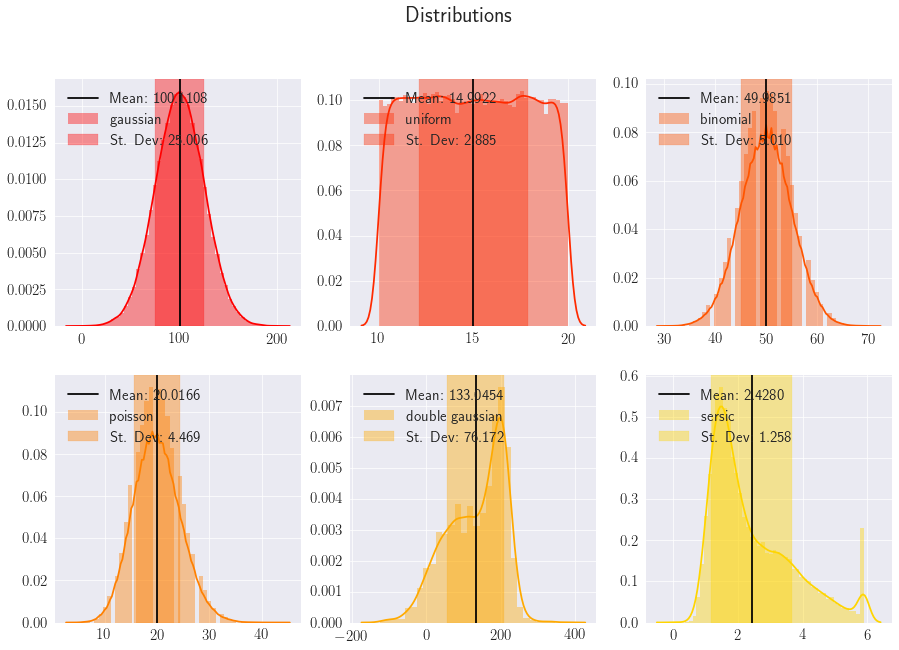

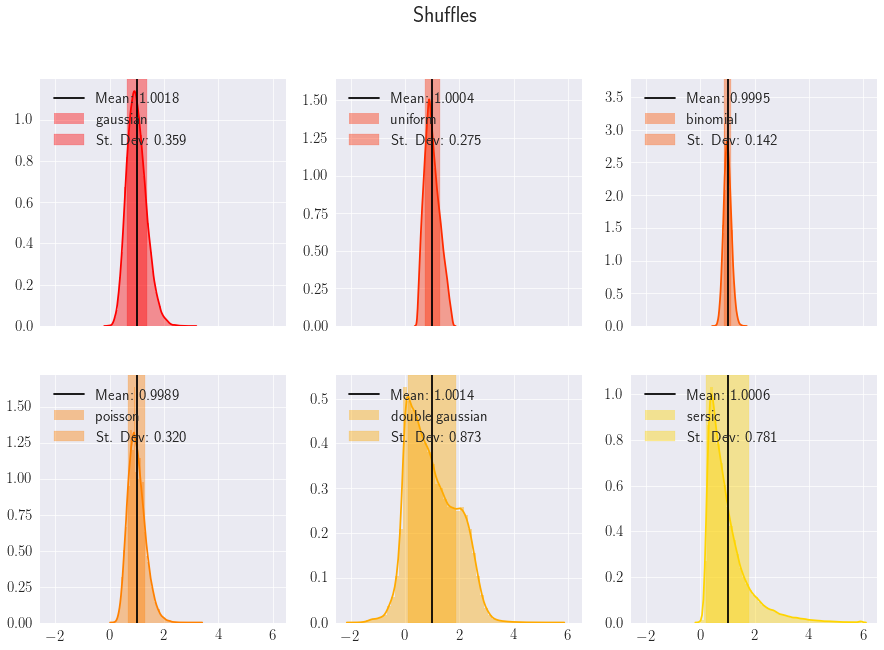

In [116]:
## Plotting results from Shuffling
distr_plotting(data_dict,fig_dir=fig_dir, savefig=True, name='Distributions')
distr_plotting(mcf_sh_dict, fig_dir=fig_dir, savefig=True, name='Shuffles', sharex=True)

## Testing MCF method on real SDSS DR7 `data`

In this section, I will put the `MCF` method to the test by applying the MCF on `sersic`, `sSFR`, and `g-r` color.
I will run a galaxy-pair-finder based on a given _projected distance_ `rp`, and evaluate the MCF for 
the three galaxy properties, i.e. sersic, sSFR, and _g-r_.

In [202]:
## Extracting galaxies that are within a given 
mgroup_bin = [11.6, 12.0]
Cens       = int(1)

DR7_catl_rp = DR7_catl.loc[(DR7_catl['M_h'] >= mgroup_bin[0]) & 
                           (DR7_catl['M_h'] <  mgroup_bin[1]) &
                           (DR7_catl['galtype'] == Cens),
                          ['ra','dec','cz','sersic','logssfr','g_r']].copy().reset_index(drop=True)

print('There is a total of {0} of galaxies in this galaxy sample!!\n\n'.format(DR7_catl_rp.shape[0]))

There is a total of 26821 of galaxies in this galaxy sample!!




### Cosmological model to use

In [203]:
def cosmo_create(cosmo_choice='LasDamas', H0=100., Om0=0.25, Ob0=0.04,
    Tcmb0=2.7255):
    """
    Creates instance of the cosmology used throughout the project.

    Parameters
    ----------
    cosmo_choice: string, optional (default = 'Planck')
        choice of cosmology
        Options:
            - Planck: Cosmology from Planck 2015
            - LasDamas: Cosmology from LasDamas simulation

    h: float, optional (default = 1.0)
        value for small cosmological 'h'.

    Returns
    ----------                  
    cosmo_model: astropy cosmology object
        cosmology used throughout the project
    """
    ## Checking cosmology choices
    cosmo_choice_arr = ['Planck', 'LasDamas']
    assert(cosmo_choice in cosmo_choice_arr)
    ## Choosing cosmology
    if cosmo_choice == 'Planck':
        cosmo_model = astrocosmo.Planck15.clone(H0=H0)
    elif cosmo_choice == 'LasDamas':
        cosmo_model = astrocosmo.FlatLambdaCDM(H0=H0, Om0=Om0, Ob0=Ob0, 
            Tcmb0=Tcmb0)
    ## Cosmo Paramters
    cosmo_params         = {}
    cosmo_params['H0'  ] = cosmo_model.H0.value
    cosmo_params['Om0' ] = cosmo_model.Om0
    cosmo_params['Ob0' ] = cosmo_model.Ob0
    cosmo_params['Ode0'] = cosmo_model.Ode0
    cosmo_params['Ok0' ] = cosmo_model.Ok0

    return cosmo_model

In [204]:
## Calculating cosmology
cosmo_model = cosmo_create(cosmo_choice='LasDamas')
cosmo_model

FlatLambdaCDM(H0=100 km / (Mpc s), Om0=0.25, Tcmb0=2.725 K, Neff=3.04, m_nu=[ 0.  0.  0.] eV, Ob0=0.04)

### Comoving distance and Cartesian coordinates of the selected galaxies

Now we can calculate the cartesian coordinates of the given galaxies' positions.

In [205]:
def spherical_to_cart(catl_pd, cosmo_model, method='astropy',
    dist_opt='astropy'):
    """
    Converts the spherical coordiates < ra dec cz > of galaxies 
    to cartesian coordinates

    Parameters
    ----------
    catl_pd: pandas DataFrame
        DataFrame with information on catalogue

    cosmo_model: astropy cosmology object
        cosmology used throughout the project

    method: string, optional (default = 'astropy')
        method to use to calculate cartesian coordinates
        Options:
            - 'astropy': uses `astropy.comoving_distance` to estimate the 
                        comoving distance to the galaxies
            - 'approx': uses approximation of `cz/H0` with an 
                        H0=100 km/s/Mpc to estimate comoving distances.
                        And it does not use `astropy` in any calculation.

    Returns
    ----------
    catl_pd: pandas DataFrame
        DataFrame with information on catalogue and with `new`
        cartesian coordinates of galaxies.
        In units of `astropy.units.Mpc` with h=1
    """
    if method=='astropy':
        ## Determining comoving distance
        c_units      = ac.c.to(u.km/u.s)
        gal_redshift = (catl_pd['cz']*(u.km/u.s))/(c_units)
        gal_dist     = cosmo_model.comoving_distance(gal_redshift).to(u.Mpc)
        ## Adding to `catl_pd`
        catl_pd.loc[:,'dist'] = gal_dist.value
        ## Spherical Coordinates
        gal_sph = SkyCoord( ra=catl_pd['ra'].values*u.degree, 
                            dec=catl_pd['dec'].values*u.degree,
                            distance=catl_pd['dist'].values*u.Mpc)
        ## Cartesian Coordinates
        gal_x, gal_y, gal_z = gal_sph.cartesian.xyz.value
    elif method=='approx':
        ## Determining comoving distance
        gal_dist     = (catl_pd['cz']*.01).values*u.Mpc
        ## Adding to `catl_pd`
        catl_pd.loc[:,'dist'] = gal_dist.value
        ## Spherical to Cartesian Coordinates
        ra_cen = dec_cen = dist_cen = 0.
        sph_dict, gal_cart = cu.Coord_Transformation(   catl_pd['ra'],
                                                        catl_pd['dec'],
                                                        catl_pd['dist'],
                                                        ra_cen,
                                                        dec_cen,
                                                        dist_cen,
                                                        trans_opt=1)
        gal_x, gal_y, gal_z = pd.DataFrame(gal_cart)[['X','Y','Z']].values.T
    ## Adding to `catl_pd`
    catl_pd.loc[:,'x'] = gal_x
    catl_pd.loc[:,'y'] = gal_y
    catl_pd.loc[:,'z'] = gal_z

    return catl_pd

In [206]:
## Cartesian Coordinates

DR7_catl_rp = spherical_to_cart(DR7_catl_rp, 'LasDamas', 'approx')
DR7_catl_rp.loc[:,'gr'] = DR7_catl_rp['g_r'].values.copy()
DR7_catl_rp[['x','y','z']].head()

,x,y,z
0,127.533708,99.816492,0.633231
1,62.211660,92.154452,0.890961
2,128.725823,100.194116,2.858226
3,132.800506,122.910832,3.256473
4,129.902967,131.153113,3.113716


### Determining the projected distance, `rp`

We will find galaxy pairs separated by a projected distance of $7 < r_{p} \leq 10\ h^{-1}\textrm{Mpc}$

In [207]:
%load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [208]:
%%cython

cimport cython
import numpy as np
cimport numpy as cnp
from libc.math cimport sqrt, log10, fabs

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)

## Functions

## Pair Counter - MCF
def pairwise_distance_rp(coord_1, coord_2, rpmin=0.01, rpmax=10, 
    nrpbins=10, pimax=20., double_count=False):
    """
    Cython engine for returning pairs of points separated in 
    projected radial bins with an observer at (0,0,0)

    Parameters
    ----------

    coord_1: array_lke, shape (N,3)
        arrays of < x | y | z > of sample 1

    coord_2: array_lke, shape (N,3)
        arrays of < x | y | z > of sample 2

    rpmin: float, optional (default = 0.01)
        minimum `rp` (perpendicular distance) to search for and return pairs

    rpmax: float, optional (default = 10.)
        maximum `rp` (perpendicular distance) to search for and return pairs

    nrpbins: int, optional (default = 10)
        total number of `rp` bins

    pimax: float, optional (default = 20.)
        maximum parallel separation distance to serach for and return pairs

    double_count: boolean, optional (default = False)
        option to decide whether or not to double count each galaxy pairs.
        Useful for the `2-halo Quenched Fractions` calculations

    Returns
    ----------
    rp_ith_arr: array-like, shape (M,3)
        three-dimensional array of M-elements containing:
        - `rp` bin number, to which galaxy pair belongs
        - i_ind: indices of 0-indexed indices in sample 1
        - j_ind: indices of 0-indexed indices in sample 2
    """
    ## -- Output Lists -- 
    rp_arr  = []
    ith_arr = []
    jth_arr = []
    ## Number of Elements
    cdef int Ni, Nj, i, j
    cdef cnp.float64_t rpbin
    Ni = len(coord_1)
    Nj = len(coord_2)
    ## -- Constants --
    cdef cnp.float64_t PI180 = 3.141592653589793/180.
    ## -- Count Pairs variables --
    cdef cnp.float64_t sx, sy, sz, lx, ly, lz, l2, ll, spar, s2, sperp
    ## -- `rp` constants
    cdef int nrpbins_p          = nrpbins
    cdef cnp.float64_t rp_min_p = rpmin
    cdef cnp.float64_t rp_max_p = rpmax
    cdef cnp.float64_t pi_max_p = pimax
    cdef cnp.float64_t logrpmin = log10(rpmin)
    cdef cnp.float64_t logrpmax = log10(rpmax)
    cdef cnp.float64_t dlogrp   = (logrpmax-logrpmin)/nrpbins
    ## -- Cartesian Coordinates --
    # Sample 1
    cdef cnp.float64_t[:] x1 = coord_1.astype(float).T[0]
    cdef cnp.float64_t[:] y1 = coord_1.astype(float).T[1]
    cdef cnp.float64_t[:] z1 = coord_1.astype(float).T[2]
    # Sample 2
    cdef cnp.float64_t[:] x2 = coord_2.astype(float).T[0]
    cdef cnp.float64_t[:] y2 = coord_2.astype(float).T[1]
    cdef cnp.float64_t[:] z2 = coord_2.astype(float).T[2]
    ## Determining if to double count or not
    if double_count:
        ## Looping over points in `coord_1`
        for i in range(0,Ni):
            ## Looping over points in `coord_2`
            for j in range(0,Nj):
                # Calculate the square distances
                sx    = x1[i] - x2[j]
                sy    = y1[i] - y2[j]
                sz    = z1[i] - z2[j]
                lx    = 0.5*(x1[i] + x2[j])
                ly    = 0.5*(y1[i] + y2[j])
                lz    = 0.5*(z1[i] + z2[j])
                l2    = (lx * lx) + (ly * ly) + (lz * lz)
                ll    = sqrt(l2)
                spar  = abs(((sx * lx) + (sy * ly) + (sz * lz)) / ll)
                s2    = (sx * sx) + (sy * sy) + (sz * sz)
                sperp = sqrt(s2 - spar * spar)
                ## Criteria for `projected separation`
                if (spar <= pi_max_p) & (sperp > rp_min_p) & (sperp < rp_max_p):
                    # `rp` bin of pair
                    rpbin = (log10(sperp) - logrpmin)/dlogrp
                    # Appending to lists
                    rp_arr.append(rpbin)
                    ith_arr.append(i)
                    jth_arr.append(j)
    else:
        ## Looping over points in `coord_1`
        for i in range(Ni):
            ## Looping over points in `coord_2`
            for j in range(i+1,Nj):
                # Calculate the square distances
                sx    = x1[i] - x2[j]
                sy    = y1[i] - y2[j]
                sz    = z1[i] - z2[j]
                lx    = 0.5*(x1[i] + x2[j])
                ly    = 0.5*(y1[i] + y2[j])
                lz    = 0.5*(z1[i] + z2[j])
                l2    = (lx * lx) + (ly * ly) + (lz * lz)
                ll    = sqrt(l2)
                spar  = abs(((sx * lx) + (sy * ly) + (sz * lz)) / ll)
                s2    = (sx * sx) + (sy * sy) + (sz * sz)
                sperp = sqrt(s2 - spar * spar)
                ## Criteria for `projected separation`
                if (spar <= pi_max_p) & (sperp > rp_min_p) & (sperp < rp_max_p):
                    # `rp` bin of pair
                    rpbin = (log10(sperp) - logrpmin)/dlogrp
                    # Appending to lists
                    rp_arr.append(rpbin)
                    ith_arr.append(i)
                    jth_arr.append(j)
    ## Converting to Numpy arrays
    rp_arr     = np.array(rp_arr).astype(int)
    ith_arr    = np.array(ith_arr).astype(int)
    jth_arr    = np.array(jth_arr).astype(int)
    # Combining arrays into a single array
    rp_ith_arr = np.column_stack((rp_arr, ith_arr, jth_arr))

    return rp_ith_arr


In [217]:
## Defining parameters for `pair counter`
rpbins  = [3, 5]
nrpbins = 1

## Putting data into correct format
coord_1 = DR7_catl_rp[['x','y','z']].values
coord_2 = coord_1.copy()

## Running pair counter
rp_ith_arr = pairwise_distance_rp(coord_1, coord_2, rpmin=rpbins[0], rpmax=rpbins[1],
                                  nrpbins=nrpbins, pimax=20., double_count=False)
rp_ith_pd = pd.DataFrame(rp_ith_arr, columns=['rp','i','j'])

In [218]:
rp_ith_pd.head()

,rp,i,j
0,0,0,6804
1,0,0,6814
2,0,0,6816
3,0,0,6837
4,0,0,17924


Now that we have all the galaxy counts in a given `rp` bin, we can calculate the `MCF`.

### Normalizing galaxy properties by their `limit` value

In [219]:
prop_lim = {'logssfr':-11,
            'sersic':3,
            'gr':0.75}

for prop in ['sersic', 'logssfr', 'gr']:
    DR7_catl_rp.loc[:,prop + '_norm'] = DR7_catl_rp[prop] / prop_lim[prop]

DR7_catl_rp.head()

,ra,dec,cz,sersic,logssfr,g_r,dist,x,y,z,gr,sersic_norm,logssfr_norm,gr_norm
0,38.049133,0.224026,16195.24,5.9033,-11.621430,0.9256,161.9524,127.533708,99.816492,0.633231,0.9256,1.967767,1.056494,1.234133
1,55.977487,0.459108,11119.14,0.9868,-10.219103,0.4483,111.1914,62.211660,92.154452,0.890961,0.4483,0.328933,0.929009,0.597733
2,37.895509,1.003827,16314.83,3.2187,-11.977286,0.9077,163.1483,128.725823,100.194116,2.858226,0.9077,1.072900,1.088844,1.210267
3,42.785181,1.031012,18097.97,1.1406,-9.719504,0.4407,180.9797,132.800506,122.910832,3.256473,0.4407,0.380200,0.883591,0.587600
4,45.274376,0.966355,18462.29,1.9056,-10.123919,0.5884,184.6229,129.902967,131.153113,3.113716,0.5884,0.635200,0.920356,0.784533


### MCF for the data
Now we can evaluate the MCF results for each of the galaxy properties

In [221]:
itern = 500
mcf_res_dict = {}
for prop in ['sersic', 'logssfr', 'gr']:
    ## Calculating MCF without `shuffles`
    prop_data = DR7_catl_rp[prop].values / np.mean(DR7_catl_rp[prop].values)
    prop_i = np.array([prop_data[xx] for xx in rp_ith_pd['i']])
    prop_j = np.array([prop_data[xx] for xx in rp_ith_pd['j']])
    mcf_res = np.sum(prop_i * prop_j) / len(prop_i)
    ##
    ## Shuffles
    mcf_res_sh = [[] for x in range(itern)]
    prop_arr   = DR7_catl_rp[prop].values.copy()
    for sh_ii in range(itern):
        # Shuffling arrays
        prop_arr_sh = prop_arr.copy()
        np.random.shuffle(prop_arr_sh)
        prop_arr_sh /= np.mean(prop_arr_sh)
        prop_i_sh = np.array([prop_arr_sh[xx] for xx in rp_ith_pd['i']])
        prop_j_sh = np.array([prop_arr_sh[xx] for xx in rp_ith_pd['j']])
        mcf_res_sh[sh_ii] = np.sum(prop_i_sh * prop_j_sh) / len(prop_i_sh)
    # To numpy array
    mcf_res_sh = np.array(mcf_res_sh)
    #
    ## Saving to dictionary
    mcf_res_dict[prop] = {}
    mcf_res_dict[prop]['mcf'   ] = mcf_res
    mcf_res_dict[prop]['mcf_sh'] = mcf_res_sh

In [257]:
def distr_plotting_MCF(mcf_res_dict, fig_dir=None, savefig=False, name=None, sharex=False, xlim=None,
                  ncols=3, nrows=1):
    """
    Plots the distributions of `data_arr`
    
    Parameters:
    -----------
    data_arr: python dictionary
        dictionary containing values of different distributions
    
    fig_dir: string or None
        path to the `figures` directory
    
    savefig: boolean, optional (default = False)
        option to save the figure to the `fig_dir` folder.
    """
    nrows = 1
    ncols = 3
    fig, axes = plt.subplots(nrows, ncols, facecolor='white', figsize=(18,6), sharex=True)
    cmap = mpl.cm.autumn
    for ii, key in enumerate(mcf_res_dict.keys()):
        ax = axes.flatten()[ii]
        color   = cmap(ii / float(len(data_dict.keys()))) 
        data_ii = mcf_res_dict[key]
        ## Mean and St. Dev.
        data_ii_mean= data_ii['mcf_sh'].mean()
        data_ii_std = data_ii['mcf_sh'].std()
        data_ii_mcf = data_ii['mcf']
        ax.axvline(x=data_ii_mean, label='Mean: {0:.04f}'.format(data_ii_mean))
        # 3-sigma
        ax.axvspan(data_ii_mean - 3*data_ii_std, data_ii_mean + 3*data_ii_std,
                    color=color,alpha=0.1, label='St. Dev: {0:.3f}'.format(data_ii_std))
        # 2-sigma
        ax.axvspan(data_ii_mean - 2*data_ii_std, data_ii_mean + 2*data_ii_std,
                    color=color, alpha=0.2)
        # 1-sigma
        ax.axvspan(data_ii_mean - data_ii_std, data_ii_mean + data_ii_std,
                    color=color, alpha=0.3)
        ## MCF Result
        ax.axvline(x=data_ii_mcf, color='grey', label='MCF - No Shuffles')
        ## Histogram
        sns.distplot(data_ii['mcf_sh'], label=key, ax=axes.flatten()[ii],color=color)
        ## Legend
        ax.legend(loc="upper left")
        ## Setting limits
        if xlim:
            ax.set_xlim(xlim)
    fig.suptitle(name)
    if savefig:
        figname = os.path.join(fig_dir, 'MCF_distr_results_props_2_{0}.png'.format(name))
        plt.savefig(figname)
        print(figname)
    

/Users/victor2/Documents/REPOSITORIES/Research/Large_Scale_Structure/SDSS/SDSS_Conformity/notebooks/figures/MCF_distr_results_props_2_Comparison of Galaxy Properties - MCF.png


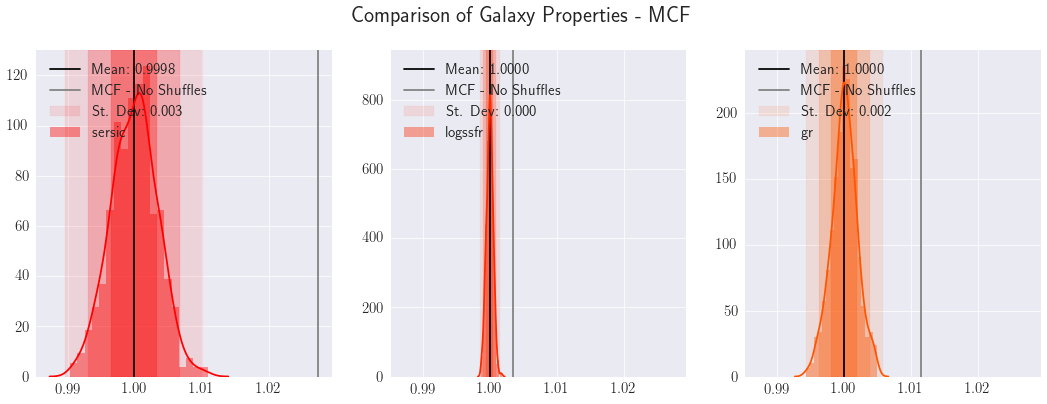

In [258]:
distr_plotting_MCF(mcf_res_dict, fig_dir=fig_dir, savefig=True, 
                   name='Comparison of Galaxy Properties - MCF', 
                   sharex=True)

## Distributions of galaxy properties

In [239]:
galprop_pd = DR7_catl_rp.loc[:,['sersic', 'logssfr', 'g_r']]
galprop_pd = galprop_pd.rename(columns={'g_r':'gr'})

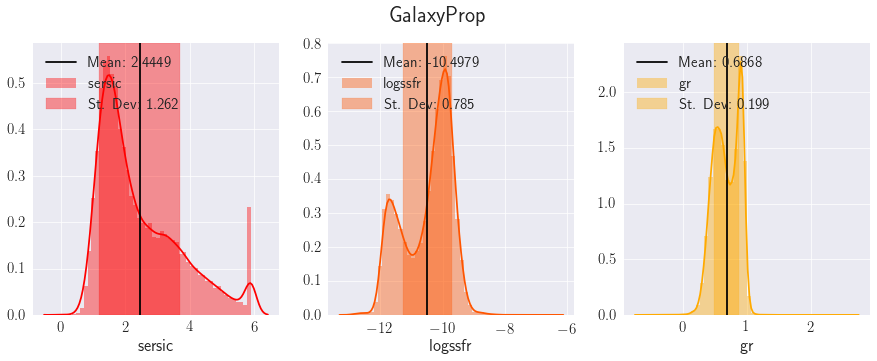

In [254]:
distr_plotting(galprop_pd,fig_dir=fig_dir, savefig=True, name='GalaxyProp', nrows=1, figsize=(15,5),ext_f='png')